# Import AFEP_parse and dependencies
AFEP_parse.py contains all the functions and library calls necessary to run the notebook

# Required modules:
- numpy
- pandas
- matplotlib
- alchemlyb (`pip install git+https://github.com/alchemistry/alchemlyb`)
- natsort (for sorting file names)
- glob (for unix-like file paths)

In [9]:
from AFEP_parse import *
import os

# User parameters

In [7]:
path='/u2/home_u2/ems363/Documents/ELIC_DCDs_Analyses/PCPGPE211/POEG_104_strongerZ/'
filename='PO*.fepout'

temperature = 303.15
RT = 0.00198720650096 * temperature

## IMPORTANT: Make sure the temperature above matches the temperature used to run the simulations.

In [10]:
fepoutFiles = glob(path+filename)
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 41 fepout files.
Total size:0.04GB


In [12]:
fepoutFiles = natsorted(fepoutFiles)
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
decorrelate = True #Flag for decorrelation of samples
detectEQ = False #Flag for automated equilibrium detection
DiscrepancyFitting = 'LS' #ML = fit PDF of discrepancies with a normal distribution maximum likelihood estimator. LS = fit CDF of discrepancies with a normal distribution least-squares estimator

# Read Data
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [13]:
if totalSize < maxSize:
    u_nk, affix = readAndProcess(fepoutFiles, temperature, decorrelate, detectEQ)
    
else:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}.\nTry the read, decorrelate, save method in the Expanded version of this notebook or increase the maxSize variable above.\nIn the future, consider using less frequent sampling (e.g. every 100 steps).")

         lambda1 = 0.15, lambda2 = 0.175; inferring lambda_idws to be 0.125
         lambda1 = 0.3, lambda2 = 0.325; inferring lambda_idws to be 0.275
         lambda1 = 0.45, lambda2 = 0.475; inferring lambda_idws to be 0.425
         lambda1 = 0.6, lambda2 = 0.625; inferring lambda_idws to be 0.575
         lambda1 = 0.75, lambda2 = 0.775; inferring lambda_idws to be 0.725
         lambda1 = 0.9, lambda2 = 0.925; inferring lambda_idws to be 0.875
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time').duplicated('time').any()
/u2/home_u2/ems363/miniconda3/envs/jupEnv/lib/python3.9/site-packages/alchemlyb/preprocessing/subsampling.py:133: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only
  return df.sort_index(0).reset_index('time

Decorrelating samples. Flag='True'


# Carry out MBAR Fitting and Analyses

In [14]:
u_nk = u_nk.sort_index(level=1)

In [15]:
bar = BAR()
bar.fit(u_nk)

BAR()

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to convert to units of kcal/mol.

In [16]:
l, l_mid, f, df, ddf, errors = get_BAR(bar)
changeAndError = f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1]*RT, 3)} kcal/mol'
print(changeAndError)

ΔG = -26.1±0.257 kcal/mol


# Plot the change in free energy based on MBAR estimates

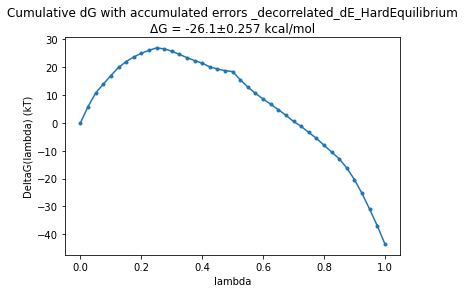

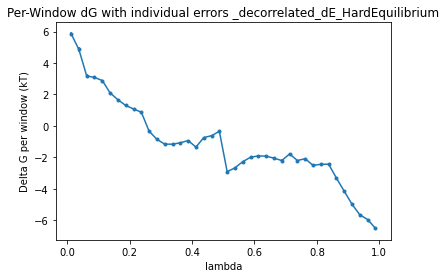

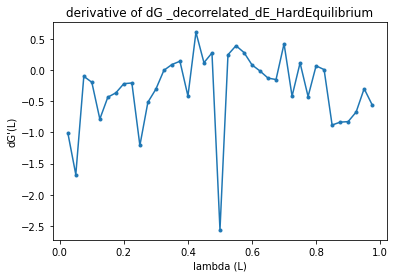

In [17]:
# Cumulative change in kT
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.title(f'Cumulative dG with accumulated errors {affix}\n{changeAndError}')
plt.savefig(f'{path}dG_cumulative_kT_{affix}.png', dpi=600)
plt.show()

# Cumulative change in kcal/mol
"""
plt.errorbar(l, f * RT, yerr=errors*RT, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.savefig(f'{path}dG_cumulative_kcal_per_mol_{affix}.png', dpi=600)
plt.show()
"""
# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.title(f'Per-Window dG with individual errors {affix}')
plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()

# Per-window change in kT

plt.errorbar(l[1:-1], np.diff(df), marker='.')
plt.xlabel('lambda (L)')
plt.ylabel("dG'(L)")
plt.title(f'derivative of dG {affix}')
plt.savefig(f'{path}dG_prime_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

In [18]:
convergence_plot(u_nk, l)
plt.title(f'Convergence {affix}')
plt.savefig(f'{path}convergence_{affix}.png', dpi=600)

KeyError: 0.05

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [19]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

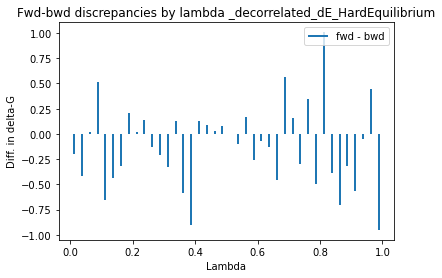

In [20]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=2)

plt.legend()
plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)

# Estimate and plot the Probability Density Function (PDF) for the differences shown above.

Note: you may wish to adjust the numBins parameter below depending on the number of windows you ran in your FEP calculation.

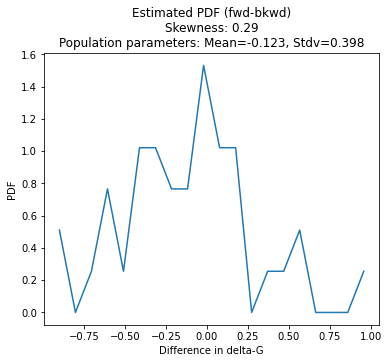

In [21]:
X, Y, pdfX, pdfY, fitted, pdfXnorm, pdfYnorm, pdfYexpected = getPDF(dG_f, dG_b)

#plot the data
fig, pdfAx = plt.subplots(1, 1)
plt.xlabel('Difference in delta-G')

pdfAx.plot(pdfX, pdfY,  label="Estimated Distribution")
pdfAx.set_ylabel("PDF")

fig.set_figheight(5)
pdfAx.title.set_text(f"Estimated PDF (fwd-bkwd)\nSkewness: {np.round(skew(X),2)}\nPopulation parameters: Mean={np.round(np.average(X),3)}, Stdv={np.round(np.std(X),3)}")
plt.savefig(f"{path}pdf_{affix}.png", dpi=600)


plt.show()